In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np

In [2]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("add")

wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: invi-bhagyesh (invi-bhagyesh-manipal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="GAN", name="DCGAN")  # Give your project a name
config = {
    "model_name": "GAN",
    
}
wandb.config.update(config)  # Log config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250411_053901-mss4mkrz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DCGAN
wandb: ⭐️ View project at https://wandb.ai/invi-bhagyesh-manipal/GAN
wandb: 🚀 View run at https://wandb.ai/invi-bhagyesh-manipal/GAN/runs/mss4mkrz


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms

# Transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom dataset loader
class CelebAUnlabeledDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Load full dataset
dataset = CelebAUnlabeledDataset(
    img_dir="/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba",
    transform=transform
)

# Train/Validation split
val_split = 0.1  # 10% for validation
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

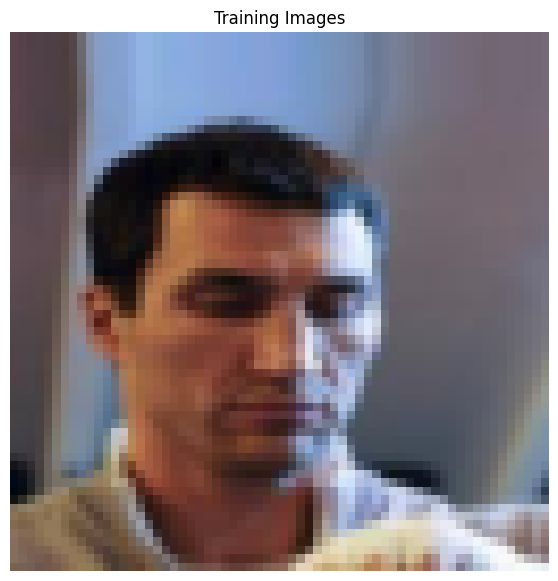

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:49], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [9]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [10]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

In [11]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [12]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [13]:
os.makedirs("saved_weights", exist_ok=True)


In [14]:
import torch
import torchvision
from tqdm import tqdm
import wandb
import os

# Initialize wandb
wandb.init(project="GAN_training", name="DCGAN_run")

# Watch models
wandb.watch([gen, disc], log="all", log_freq=100)

# Make sure directory exists for saving weights
os.makedirs("saved_weights", exist_ok=True)

gen.train()
disc.train()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)

    for batch_idx, real in loop:
        real = real.to(device)

        ### Generate fake images
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### tqdm progress bar update
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss_D=loss_disc.item(), loss_G=loss_gen.item())

        ### Log training losses
        wandb.log({
            "Train Loss Discriminator": loss_disc.item(),
            "Train Loss Generator": loss_gen.item(),
            "Epoch": epoch
        })

    ### Log generated images every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise)
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
            wandb.log({
                "Generated Images": [wandb.Image(img_grid_fake, caption=f"Fake Images at Epoch {epoch+1}")],
                "Epoch": epoch
            })

    ### Save model weights every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(gen.state_dict(), f"saved_weights/gen_epoch_{epoch+1}.pth")
        torch.save(disc.state_dict(), f"saved_weights/disc_epoch_{epoch+1}.pth")
        wandb.save(f"saved_weights/gen_epoch_{epoch+1}.pth")
        wandb.save(f"saved_weights/disc_epoch_{epoch+1}.pth")

    ### Validation loss logging
    gen.eval()
    disc.eval()

    val_loss_disc = 0
    val_loss_gen = 0

    with torch.no_grad():
        for val_real in val_dataloader:
            val_real = val_real.to(device)
            val_noise = torch.randn(val_real.size(0), Z_DIM, 1, 1).to(device)
            val_fake = gen(val_noise)

            # Discriminator Validation Loss
            disc_real_val = disc(val_real).reshape(-1)
            disc_fake_val = disc(val_fake).reshape(-1)

            loss_disc_real_val = criterion(disc_real_val, torch.ones_like(disc_real_val))
            loss_disc_fake_val = criterion(disc_fake_val, torch.zeros_like(disc_fake_val))
            val_loss_disc += ((loss_disc_real_val + loss_disc_fake_val) / 2).item()

            # Generator Validation Loss
            output_val = disc(val_fake).reshape(-1)
            loss_gen_val = criterion(output_val, torch.ones_like(output_val))
            val_loss_gen += loss_gen_val.item()

    val_loss_disc /= len(val_dataloader)
    val_loss_gen /= len(val_dataloader)

    wandb.log({
        "Val Loss Discriminator": val_loss_disc,
        "Val Loss Generator": val_loss_gen,
        "Epoch": epoch
    })

    gen.train()
    disc.train()

In [15]:
# Save generator and discriminator models
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")
print("✅ Models saved as 'generator.pth' and 'discriminator.pth'")

✅ Models saved as 'generator.pth' and 'discriminator.pth'


In [16]:
wandb.finish()

wandb: uploading saved_weights/disc_epoch_50.pth; uploading saved_weights/gen_epoch_40.pth; uploading saved_weights/disc_epoch_20.pth; uploading saved_weights/disc_epoch_30.pth; uploading saved_weights/gen_epoch_50.pth (+ 5 more)
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                    Epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇██
wandb: Train Loss Discriminator ▃█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▂▁▁▁▁▁▄▁▂▁
wandb:     Train Loss Generator ▁▂▁▁▁▂▁██████▂▁▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▂▂▂▃
wandb:   Val Loss Discriminator ▁▁▁▁▁████████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
wandb:       Val Loss Generator ▁▁▁▁▁█████▇▇▇▇▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:                    Epoch 49
wandb: Train Loss Discriminator 0.05686
wandb:     Train Loss Generator 4.39068
wandb:   Val Loss Discriminator 0.41481
wandb:       Val Loss Generator 3.59384
wandb: 
wandb: 🚀 View run DCGAN at: https://wandb.ai/invi-bhagyesh-